## Implement of a curvature

Here we compute the transport map $\mathbf{O}_{ij}:= \mathscr{F}^T_{v \unlhd e}\mathscr{F}_{u \unlhd e}$ according to  https://arxiv.org/pdf/2206.08702.pdf and https://arxiv.org/pdf/1102.0075.pdf

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import pandas as pd

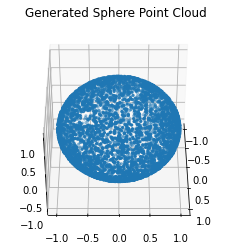

In [2]:
def generate_sphere_point_cloud(num_points, radius=1):
    phi = np.random.uniform(0, 2 * np.pi, num_points)
    theta = np.arccos(2 * np.random.uniform(0, 1, num_points) - 1)

    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)

    return np.column_stack((x, y, z))

#parameters 

n_samples = 5000
d = 2
ep = np.sqrt(n_samples ** ( - 2 / (d + 1)))
ep

# Generate a sphere point cloud with 1000 points and radius 1
sphere_cloud = generate_sphere_point_cloud(n_samples, radius=1)

# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sphere_cloud[:, 0], sphere_cloud[:, 1], sphere_cloud[:, 2], s=5)
ax.set_title("Generated Sphere Point Cloud")
ax.view_init(40, 0)
plt.show()

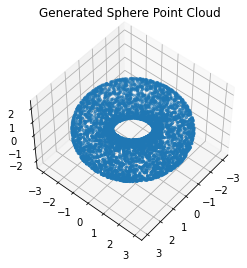

In [3]:
def generate_torus_point_cloud(num_points = 5000, R = 3, r = 1):
    # Generate random angles for theta and phi
    theta = np.random.uniform(0, 2*np.pi, num_points)
    phi = np.random.uniform(0, 2*np.pi, num_points)

    # Compute the torus points
    x = (R + r * np.cos(phi)) * np.cos(theta)
    y = (R + r * np.cos(phi)) * np.sin(theta)
    z = r * np.sin(phi)

    return np.column_stack((x, y, z))

# Create torus parameters
R = 2 # Major radius
r = 1  # Minor radius
num_samples = 5000



# Generate a sphere point cloud with 1000 points and radius 1
torus_cloud = generate_torus_point_cloud(num_points = num_samples, R = R, r = r)

# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(torus_cloud[:, 0], torus_cloud[:, 1], torus_cloud[:, 2], s=5)
ax.set_aspect('equal')
ax.set_title("Generated Sphere Point Cloud")
ax.view_init(50, 40)
plt.show()

In [4]:
def sub_vectors_between(set_vectors, a, b):
    # this function selects a set of vectors whose entries are between a and b
    
    filtered_vector = [[x for x in v if a < x < b] for v in set_vectors ]
    return filtered_vector        

def list_vector_indices_upto(list_indices, list_of_nums):
    result_list = [[list_indices[i][j] for j in range(list_of_nums[i] + 1)] for i in range(len(list_indices))]
    return result_list

def list_vector_of_index(set_vectors, list_indices):
    
    list_result_vectors = [np.array([set_vectors[i] for i in list_indices[j]]) for j in range(len(list_indices))]
    return list_result_vectors 



def find_basis(point_cloud, x, epsilon_PCA = 0.1, dim = 2, tau_ratio = 1.5):
    #point_cloud: the manifold 
    #x: np.array of shape 1 by p, the point where the curvature is evaluated at, e.g., [[1, 2, 3]]
    #epsilon: the radius of local PCA
    #dim: the dimension of the manifold
    #tau_ratio: the ratio is tau radius (where we evaluate the curvature)/ epsilon_sqrt
    epsilon_sqrt = np.sqrt(epsilon_PCA)
    tau = tau_ratio * epsilon_sqrt

    # Number of neighbors to find, we take 5% of the total population
    k = int(0.05 * point_cloud.shape[0])
    
    # Create a NearestNeighbors model
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(point_cloud)

    # Find k nearest neighbors
    dist_i, indx_i = nbrs.kneighbors(x)
    # Find epsilon neighborhood
    dist_epsilon = sub_vectors_between(dist_i, 0, epsilon_sqrt)
    len_dist_epsilon = [len(v) for v in dist_epsilon]
    epsilon_neighborhood = list_vector_of_index(point_cloud, list_vector_indices_upto(indx_i, len_dist_epsilon))[0]
    # Find tau neighborhood
    dist_tau = sub_vectors_between(dist_i, 0, tau)
    len_dist_tau = [len(v) for v in dist_tau]
    tau_neighborhood = list_vector_of_index(point_cloud, list_vector_indices_upto(indx_i, len_dist_tau))[0]
    num = len(tau_neighborhood)
    
    distances, indices = nbrs.kneighbors(tau_neighborhood)
    
    distances_epsilon = sub_vectors_between(distances, 0, epsilon_sqrt) # this is the list of distances in the epsilon
    list_len_dist_epsilon = [len(v) for v in distances_epsilon] #this gives the list of lengths in the distance_epsilon 
    
    tau_epsilon_neighborhood = list_vector_of_index(point_cloud, list_vector_indices_upto(indices, list_len_dist_epsilon))
    list_X_i = [tau_epsilon_neighborhood[i][1:] - tau_neighborhood[i] for i in range(num)]
    
    
    #list_D_i = [np.diag(np.sqrt(np.exp(- np.array(distances_epsilon[i]) ** 2 / epsilon_PCA))) for i in range(num)]
    list_D_i = [np.diag(np.sqrt(np.exp( - 5 * np.array(distances_epsilon[i]) ** 2 / epsilon_PCA))) for 
                i in range(num)]
    list_B_i = [list_X_i[j].T @ list_D_i[j] for j in range(num)]
    O = []
    for q in range(num):
        U, S, VT = np.linalg.svd(list_B_i[q], full_matrices = False)
        O_i = U[:dim, :]
        O.append(O_i)
        
    return epsilon_neighborhood, tau_neighborhood, tau_epsilon_neighborhood, O



In [9]:
def compute_curvature(point_cloud, query_point, epsilon_PCA = 0.1, dim = 2, tau_ratio = 1.5):
    
    ep_neighbor, tau_neighbor, tau_epsilon_neighbor, O = find_basis(point_cloud, query_point, epsilon_PCA = epsilon_PCA,
                                                                    dim = dim, tau_ratio = tau_ratio)
    
    transport_maps = np.zeros((len(tau_neighbor), len(tau_neighbor), 3, 3))
    for i in range(len(tau_neighbor)):
        for j in range(len(tau_neighbor)):
            U, S, VT = np.linalg.svd(O[i].T @ O[j], full_matrices = False)
            O_ij = U @ VT
            transport_maps[i,j] = O_ij
            
    tensor_av = []
    
    """
    v_init = O[0][1]
    for i in np.arange(1, len(tau_neighbor)):
        for j in np.arange(i + 1, len(tau_neighbor)):
            #v_init = tau_neighbor[1] - tau_neighbor[0]
            v_mid_1 = transport_maps[i, j] @ transport_maps[0, i] @ v_init
            
            v_mid_2 = transport_maps[0, j] @ v_init
            
            cosin = (v_mid_1 @ v_mid_2.T) / (np.linalg.norm(v_mid_1) * np.linalg.norm(v_mid_2))
            angle = np.arccos(cosin)
            area = np.linalg.norm(np.cross(tau_neighbor[i] - tau_neighbor[0], tau_neighbor[j] - tau_neighbor[0])) / 2
            
            #tensor = (angle - np.pi)/ area
            tensor = angle / area
            
            tensor_av.append(tensor)
    tensor_av = sum(tensor_av)/len(tensor_av) * 0.01
    """
    
    """
    for i in np.arange(1, len(tau_neighbor)):
        for j in np.arange(i + 1, len(tau_neighbor)):
            for k in np.arange(1, len(tau_neighbor)):
                if k != j and k!= i:
                    v_init = tau_neighbor[1] - tau_neighbor[0]
                    v_fin = transport_maps[k, 0] @ transport_maps[j, k] @ transport_maps[i, j] @ transport_maps[0, i] @ v_init
            
                    cosin = (v_init @ v_fin.T) / (np.linalg.norm(v_init) * np.linalg.norm(v_fin))
                    angle = np.arccos(cosin)
                    area = np.linalg.norm(np.cross(tau_neighbor[i] - tau_neighbor[0], tau_neighbor[j] - tau_neighbor[0])) / 2 + np.linalg.norm(np.cross(tau_neighbor[j] - tau_neighbor[0], tau_neighbor[k] - tau_neighbor[0])) / 2
            
                    #tensor = (2 * np.pi - angle) / area
                    tensor = angle / area
            
                    tensor_av.append(tensor)
    tensor_av = np.sqrt(sum(tensor_av)/len(tensor_av) * 0.01)
        
        
    """
    """

    #this version gives the donut symmetrical on inner and outter boundary
    v_init = O[0][1]
    
    for i in np.arange(1, len(tau_neighbor)):
        for j in np.arange(i + 1, len(tau_neighbor)):
            for k in np.arange(1, len(tau_neighbor)):
                if k != j and k!= i: 
                    #v_init = tau_neighbor[1] - tau_neighbor[0]
                    
                    v_fin = transport_maps[k, 0] @ transport_maps[j, k] @ transport_maps[i, j] @ transport_maps[0, i] @ v_init
        
                    cosin = (v_init @ v_fin.T) / (np.linalg.norm(v_init) * np.linalg.norm(v_fin))
                
                    #sign = np.sign(np.dot(O[0][0], v_fin))
                    #angle = sign * np.arccos(cosin)
                    
                    angle = np.arccos(cosin)
                    area = np.linalg.norm(np.cross(tau_neighbor[i] - tau_neighbor[0], tau_neighbor[j] - tau_neighbor[0])) / 2 + np.linalg.norm(np.cross(tau_neighbor[j] - tau_neighbor[0], tau_neighbor[k] - tau_neighbor[0])) / 2
            
                    #tensor = (2 * np.pi - angle) / area
                    tensor = angle / area
            
                    tensor_av.append(tensor)
    
    tensor_av = sum(tensor_av)/len(tensor_av) * 0.01
    """
    
    v_init = O[0][0]
    
    for i in np.arange(1, len(tau_neighbor)):
        for j in np.arange(1, len(tau_neighbor)):
            if i != j:
                for k in np.arange(1, len(tau_neighbor)):
                    if k != j and k!= i: 
                        v_oi = tau_neighbor[i] - tau_neighbor[0]
                        v_oj = tau_neighbor[j] - tau_neighbor[0]
                        v_ij = tau_neighbor[j] - tau_neighbor[i]
                        #the following is to compute the vector v_oi projection on v_oj
                        v_i_proj = (v_oi @ v_oj.T)/(v_oj @ v_oj.T) * v_oj
                        v_i_perp = v_i_proj - v_oi
                        
                        #the following is to compute the vector v_ij projection on v_oi
                        v_ij_proj = (v_ij @ v_oi.T)/(v_oi @ v_oi.T) * v_oi
                        v_ij_perp = v_ij_proj - v_ij
                        
                        #the following is to determine the point k if it can form a quadrilateral
                        v_jk = tau_neighbor[k] - tau_neighbor[j]
                        cond_1 = v_ij @ v_oj.T
                        cond_2 = v_jk @ v_i_perp.T
                        cond_3 = v_jk @ v_ij_perp.T
    
                        if (cond_1 < 0.001 and cond_2 > 0.001 and cond_3 > 0.001) or (cond_1 >= 0 and cond_2 > 0):
                    
                            #v_mid_1 = transport_maps[i, j] @ transport_maps[0, i] @ v_init
                            #v_mid_2 = transport_maps[k, j] @ transport_maps[0, k] @ v_init
                
                            #cosin = (v_mid_1 @ v_mid_2.T) / (np.linalg.norm(v_mid_1) * np.linalg.norm(v_mid_2))
                    
                            #diff = v_fin - v_init
                            #sign = np.sign(diff[0] * diff[1] * diff[2])
                            v_fin = transport_maps[k, 0] @ transport_maps[j, k] @ transport_maps[i, j] @ transport_maps[0, i] @ v_init
        
                            cosin = (v_init @ v_fin.T) / (np.linalg.norm(v_init) * np.linalg.norm(v_fin))
                
                            angle = np.arccos(cosin)
                    
                            area = np.linalg.norm(np.cross(tau_neighbor[i] - tau_neighbor[0], tau_neighbor[j] - tau_neighbor[0])) / 2 + np.linalg.norm(np.cross(tau_neighbor[j] - tau_neighbor[0], tau_neighbor[k] - tau_neighbor[0])) / 2
            
                            tensor = (2 * np.pi - angle) / area
            
                            tensor_av.append(tensor)
    
    tensor_av = sum(tensor_av)/len(tensor_av) * 0.01

    
            
    return transport_maps, tensor_av         
    
    

In [59]:
for i in tqdm(np.arange(1010, 1011)):
    a, b = compute_curvature(sphere_cloud, np.expand_dims(sphere_cloud[i], axis=0), epsilon_PCA = 0.1, tau_ratio = 1)
    print(b)

100%|██████████| 1/1 [01:29<00:00, 89.99s/it]

0.5686151784560746


In [60]:
c = []
for i in tqdm(np.arange(1020, 1030)):
    a, b = compute_curvature(torus_cloud, np.expand_dims(torus_cloud[i], axis=0), epsilon_PCA = 0.2, tau_ratio = 1)
    print(b)
    c.append(b)


 10%|█         | 1/10 [00:00<00:04,  1.89it/s]

0.2564590224282207


 20%|██        | 2/10 [00:23<01:51, 13.98s/it]

0.21795784981090824


 30%|███       | 3/10 [00:29<01:12, 10.32s/it]

0.3452024745495412


 40%|████      | 4/10 [00:30<00:39,  6.55s/it]

0.17585726723105857


 50%|█████     | 5/10 [00:34<00:28,  5.62s/it]

0.23762236858909638


 60%|██████    | 6/10 [00:42<00:25,  6.40s/it]

0.38053140168174837


 70%|███████   | 7/10 [00:59<00:29,  9.92s/it]

0.19514381899182284


 80%|████████  | 8/10 [01:13<00:22, 11.24s/it]

0.37551942917527664


 90%|█████████ | 9/10 [01:47<00:18, 18.33s/it]

0.17963653842550473


100%|██████████| 10/10 [01:48<00:00, 10.89s/it]

0.18469104252170515


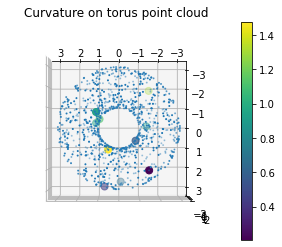

In [29]:
# Visualize the point cloud
c = np.array(c)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(torus_cloud[:1000, 0], torus_cloud[:1000, 1], torus_cloud[:1000, 2], s=1)
scatter = ax.scatter(torus_cloud[1020:1030, 0], torus_cloud[1020:1030, 1], torus_cloud[1020:1030, 2], s=50, c = c)
ax.set_title("Curvature on torus point cloud")
ax.view_init(90, 90)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

In [8]:
# Choose the point for which you want to find k nearest neighbors
query_point_i = np.array([sphere_cloud[101]])

ep_neighbor, tau_neighbor, tau_epsilon_neighbor, O = find_basis(sphere_cloud, query_point_i)

In [12]:
np.linalg.norm(O[0][0])

1.0

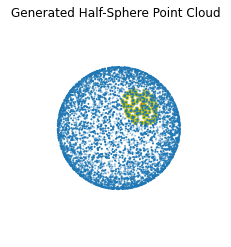

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sphere_cloud[:, 0], sphere_cloud[:, 1], sphere_cloud[:, 2], s=1)
ax.scatter(query_point_i[:, 0], query_point_i[:, 1], query_point_i[:, 2], c = "r", s = 20)
ax.scatter(ep_neighbor[:, 0], ep_neighbor[:, 1], ep_neighbor[:, 2], c = "y", s = 10)
ax.set_title("Generated Half-Sphere Point Cloud")
ax.view_init(90, 0)
plt.axis('off')
plt.show()

In [10]:

num_eval = int(len(torus_cloud)/5)

curvature = []
for i in tqdm(range(num_eval)):
    a, b = compute_curvature(torus_cloud, np.expand_dims(torus_cloud[i], axis=0), epsilon_PCA = 0.1, tau_ratio = 1)
    curvature.append(b)

100%|██████████| 1000/1000 [20:06<00:00,  1.21s/it]


In [11]:
from numpy import savetxt
v = np.array(curvature).T
savetxt('curvature.csv', v, delimiter=',')

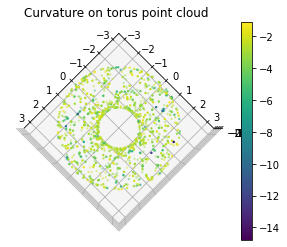

In [12]:
# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(torus_cloud[:num_eval, 0], torus_cloud[:num_eval, 1], torus_cloud[:num_eval, 2], s=2, c = -v)
ax.set_title("Curvature on torus point cloud")
ax.view_init(90, 45)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

## Use triangle

In [5]:
def compute_curvature_v2(point_cloud, query_point, epsilon_PCA = 0.1, dim = 2, tau_ratio = 1.5):
    
    ep_neighbor, tau_neighbor, tau_epsilon_neighbor, O = find_basis(point_cloud, query_point, epsilon_PCA = epsilon_PCA,
                                                                    dim = dim, tau_ratio = tau_ratio)
    
    transport_maps = np.zeros((len(tau_neighbor), len(tau_neighbor), 3, 3))
    for i in range(len(tau_neighbor)):
        for j in range(len(tau_neighbor)):
            U, S, VT = np.linalg.svd(O[i].T @ O[j], full_matrices = False)
            O_ij = U @ VT
            transport_maps[i,j] = O_ij
            
    tensor_av = []

    """
    #v_init = O[0][1]
    for i in np.arange(1, len(tau_neighbor)):
        for j in np.arange(i + 1, len(tau_neighbor)):
            v_init = tau_neighbor[1] - tau_neighbor[0]
            v_mid_1 = transport_maps[i, j] @ transport_maps[0, i] @ v_init
            
            v_mid_2 = transport_maps[0, j] @ v_init
            
            cosin = (v_mid_1 @ v_mid_2.T) / (np.linalg.norm(v_mid_1) * np.linalg.norm(v_mid_2))
            angle = np.arccos(cosin)
            area = np.linalg.norm(np.cross(tau_neighbor[i] - tau_neighbor[0], tau_neighbor[j] - tau_neighbor[0])) / 2
            
            tensor = (2 * np.pi - angle) / area
            #tensor = angle / area
    """
    v_init_1 = O[0][0]
    v_init_2 = O[0][1]
    
    for i in np.arange(1, len(tau_neighbor)):
        for j in np.arange(i + 1, len(tau_neighbor)):
            #v_init = tau_neighbor[1] - tau_neighbor[0]
            v_fin_1 = transport_maps[j, 0] @ transport_maps[i, j] @ transport_maps[0, i] @ v_init_1
            v_fin_2 = transport_maps[i, 0] @ transport_maps[j, i] @ transport_maps[0, j] @ v_init_2
            
            cosin_1 = (v_init_1 @ v_fin_1.T) / (np.linalg.norm(v_init_1) * np.linalg.norm(v_fin_1))
            cosin_2 = (v_init_2 @ v_fin_2.T) / (np.linalg.norm(v_init_2) * np.linalg.norm(v_fin_2))
            angle_1 = np.arccos(cosin_1)
            angle_2 = np.arccos(cosin_2)
            
            area = np.linalg.norm(np.cross(tau_neighbor[i] - tau_neighbor[0], tau_neighbor[j] - tau_neighbor[0]))/2
            
            #tensor = (2 * np.pi - angle) / area
            tensor = (angle_1 + angle_2) / area
            #tensor = angle / area
            
            tensor_av.append(tensor)
    tensor_av = np.sqrt(sum(tensor_av)/len(tensor_av) * 0.01)
         
    return transport_maps, tensor_av 
 

In [6]:

num_eval = int(len(torus_cloud)/5)

curvature = []
for i in tqdm(range(num_eval)):
    a, b = compute_curvature_v2(torus_cloud, np.expand_dims(torus_cloud[i], axis=0), epsilon_PCA = 0.1, tau_ratio = 1)
    curvature.append(b)


100%|██████████| 1000/1000 [00:38<00:00, 25.98it/s]


In [7]:
from numpy import savetxt
v = np.array(curvature).T
savetxt('curvature.csv', v, delimiter=',')

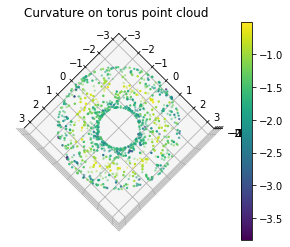

In [8]:
df = pd.read_csv('curvature.csv', sep=',', header=None)
v = df.squeeze()
# Visualize the point cloud
cc = -v
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(torus_cloud[:num_eval, 0], torus_cloud[:num_eval, 1], torus_cloud[:num_eval, 2], s=2, c = cc)
ax.set_title("Curvature on torus point cloud")
ax.view_init(90, 45)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

In [50]:
mask = cc < -10
cc[mask]
cc_clipped = np.clip(cc, -5, -2)


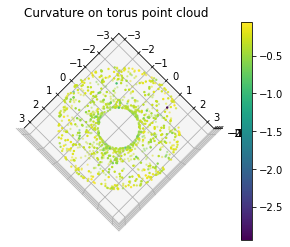

In [13]:
# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(torus_cloud[:num_eval, 0], torus_cloud[:num_eval, 1], torus_cloud[:num_eval, 2], s=2, c = -v + 0.8)
ax.set_title("Curvature on torus point cloud")
ax.view_init(90, 45)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

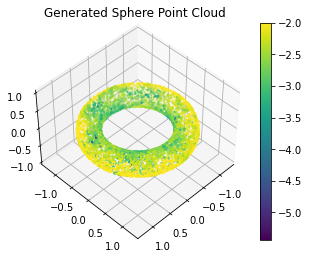

In [126]:
# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(torus_cloud[:, 0], torus_cloud[:, 1], torus_cloud[:, 2], s=2, c = v1)
ax.set_title("Generated Sphere Point Cloud")
ax.view_init(45, 45)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

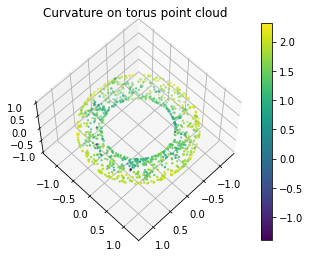

In [99]:
# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(torus_cloud[:num_eval, 0], torus_cloud[:num_eval, 1], torus_cloud[:num_eval, 2], s=2, c = v + 4)
ax.set_title("Curvature on torus point cloud")
ax.view_init(60, 45)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

In [122]:
from tqdm import tqdm
num_eval = int(len(sphere_cloud)/10)

curvature_sphere = []
for i in tqdm(range(num_eval)):
    a, b = compute_curvature(sphere_cloud, np.expand_dims(sphere_cloud[i], axis=0), epsilon_PCA = 0.05, tau_ratio = 10)
    curvature_sphere.append(b)

100%|██████████| 500/500 [21:35<00:00,  2.59s/it]


In [123]:
v_s = - np.array(curvature_sphere).T

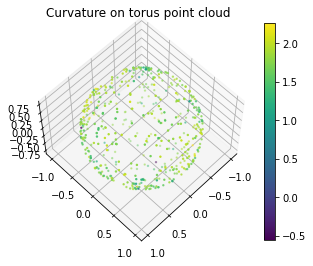

In [124]:
# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(sphere_cloud[:num_eval, 0], sphere_cloud[:num_eval, 1], sphere_cloud[:num_eval, 2], s=2, c = v_s + 4)
ax.set_title("Curvature on torus point cloud")
ax.view_init(60, 45)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()